In [119]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from scipy.misc import derivative
import time

In [120]:
data= pd.read_csv("MGH10_Data.txt",names=['y','x'], sep=" ")

data

,y,x
NaN,34780.0,50.0
NaN,28610.0,55.0
NaN,23650.0,60.0
NaN,19630.0,65.0
NaN,16370.0,70.0
NaN,13720.0,75.0
NaN,11540.0,80.0
NaN,9744.0,85.0
NaN,8261.0,90.0
NaN,7030.0,95.0


In [121]:
y = torch.from_numpy(data['y'].to_numpy(np.float64))
x = torch.from_numpy(data['x'].to_numpy(np.float64))

b = torch.tensor([0.02,4000.0,250.0],requires_grad=True)
# b = torch.tensor([2.0,400000.0,25000.0],requires_grad=True)

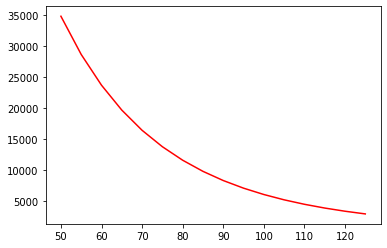

In [122]:
plt.plot(x.numpy(),y.numpy(),"r")

In [123]:
## Numerical Differentiation

b = np.array([100.0,10.0,1.0,1.0]).reshape(-1,1)
b = np.array([0.02,4000.0,250.0]).reshape(-1,1)

x=x.detach().numpy()

u=0.1 #beta multiply identity matrix
beta = 10
V_prev = 0


def f0(b0):
    return  b0*np.exp(b[1]/(x+b[2])) -y.detach().numpy()  
def f1(b1):
    return b[0]*np.exp(b1/(x+b[2]))-y.detach().numpy()  
def f2(b2):
    return  b[0]*np.exp(b[1]/(x+b2)) -y.detach().numpy()  


start_time = time.perf_counter()
for c in range(500):
    
    y_pred = b[0]*np.exp(b[1]/(x+b[2]))
    error = (y_pred - y.detach().numpy()).reshape(-1,1)
    
    d_b0 = derivative(f0,b[0] , dx=1e-6)
    d_b1 = derivative(f1,b[1] , dx=1e-6)
    d_b2 = derivative(f2,b[2] , dx=1e-6)
     
    jacobian = np.transpose(np.array([d_b0,d_b1,d_b2]))
    dParam = np.matmul(np.matmul(np.linalg.inv((np.matmul(np.transpose(jacobian),jacobian)+u*np.identity(len(b)))),np.transpose(jacobian)),error)
    b -= dParam
    V = np.sum(np.square(error))
    if(V > V_prev):
            u *= beta
    else:
            u /= beta
    V_prev = V
    print("c: ",c," error: ",V," B:", b)
    if V < 8.7945859E+01:
        break
print("time taken to execute: ",time.perf_counter()-start_time) 
print("SD error is", np.std(np.square(loss.detach().numpy())))

c:  0  error:  1693607809.4361455  B: [[8.60621757e-02]
 [4.18153237e+03]
 [2.96892031e+02]]
c:  1  error:  1179988448.4909174  B: [[2.04728072e-02]
 [4.19224647e+03]
 [2.36850498e+02]]
c:  2  error:  191655054.18997768  B: [[5.75147020e-02]
 [3.78826098e+03]
 [2.49387471e+02]]
c:  3  error:  945626514.2759025  B: [[-2.49091191e-02]
 [ 5.60261278e+03]
 [ 3.36708347e+02]]
c:  4  error:  23100681610.38656  B: [[8.61733995e-03]
 [5.55250245e+03]
 [3.43047728e+02]]
c:  5  error:  1634475346.1566615  B: [[7.53998685e-03]
 [5.55398026e+03]
 [2.85254123e+02]]
c:  6  error:  17380570859.85544  B: [[1.30450401e-02]
 [4.93567561e+03]
 [2.76991894e+02]]
c:  7  error:  303025952.2744232  B: [[2.06509823e-02]
 [4.92754467e+03]
 [2.94676549e+02]]
c:  8  error:  12825793.491597738  B: [[2.15702305e-02]
 [5.11645406e+03]
 [3.07924660e+02]]
c:  9  error:  20625.002041582964  B: [[3.35796797e-03]
 [5.75032626e+03]
 [3.31150665e+02]]
c:  10  error:  1671750957.0141044  B: [[6.30257006e-03]
 [6.51551168e+

In [124]:
def Jacobian(loss,params,numParams):
    
    jacobian = torch.empty(len(loss), numParams) 
    
    for i in range(len(loss)):
        
        loss[i].backward(retain_graph=True)
        
        for n in range(numParams):
            jacobian[i][n] = params.grad[n]
        params.grad.zero_()      
    return jacobian    

In [125]:
## Automatic Differentiation
num_param = len(b)
u=0.1 #beta multiply identity matrix
beta = 10
error_prev = 0
start_time = time.perf_counter()
for c in range(500):
    
    y_pred = b[0]*torch.exp(b[1]/(x+b[2]))
    
    loss = y_pred-y
    error = torch.sum(torch.square(loss)) #residual sum of squares
    print("",c," error is: ",error.detach().numpy()," b is ", b.detach().numpy())
    jacobian = Jacobian(loss,b,len(b))

    dParam = torch.matmul(torch.matmul(torch.inverse(torch.matmul(torch.transpose(jacobian,-1,0),jacobian)+u*torch.eye(num_param, num_param)),torch.transpose(jacobian,-1,0)),loss.float())
    with torch.no_grad():
        b -=dParam
    
        if(error > error_prev):
            u *= beta
        else:
            u /= beta
        error_prev = error
    if error<  8.794586E+01: # given residual sum of squares
        break
print("time taken to execute: ",time.perf_counter()-start_time) 
print("SD error is", np.std(np.square(loss.detach().numpy())))

TypeError: exp(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
plt.plot(y_pred.detach(),'g', y,'r.')

In [ ]:
y_pred = b[0] / (torch.pow(1+torch.exp(b[1]-b[2]*x),(1/b[3])))

